In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
from sklearn import linear_model

# Load training and testing data
X_train = np.loadtxt('X_train.csv', delimiter=',', skiprows=1)
X_test = np.loadtxt('X_test.csv', delimiter=',', skiprows=1)
y_train = np.loadtxt('y_train.csv', delimiter=',', skiprows=1)[:,1]
y_traindf = pd.read_csv('y_train.csv')
X_traindf = pd.read_csv('X_train.csv')
X_testdf = pd.read_csv('X_test.csv')
# Lets have all the variables in the same dataframe
df = pd.read_csv('X_train.csv')
df['PRP'] = y_traindf['PRP']


# Fit model and predict test values
#y_pred = np.random.randint(y_train.min(), y_train.max(), X_test.shape[0])

# Arrange answer in two columns. First column (with header "Id") is an
# enumeration from 0 to n-1, where n is the number of test points. Second
# column (with header "EpiOrStroma" is the predictions.
#
#np.savetxt('my_submission.csv', y_pred_pp, fmt='%d,%f', delimiter=",",
#           header=test_header, comments="")

# Note: fmt='%d' denotes that all values should be formatted as integers which
# is appropriate for classification. For regression, where the second column
# should be floating point, use fmt='%d,%f'.
    

Note that it might be a good idea to transform one or more features into new features using basis functions. 
For instance, could the minimum and maximum memory features meaningfully be combined to one?

In [2]:
#Reshape ytrain to be two columns
#ytrain = np.reshape(y_train,(len(y_train),1))
MYCT = X_train[:,0]
MMIN = X_train[:,1]
MMAX = X_train[:,2]
CACH = X_train[:,3]
CHMIN = X_train[:,4]
CHMAX = X_train[:,5]
X_traindf

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,125,256,6000,256,16,128
1,29,8000,32000,32,8,32
2,29,8000,32000,32,8,32
3,29,8000,32000,32,8,32
4,29,8000,16000,32,8,16
5,23,16000,32000,64,16,32
6,23,16000,64000,64,16,32
7,23,32000,64000,128,32,64
8,400,1000,3000,0,1,2
9,400,512,3500,4,1,6


What variables should we consider? Are all of them important? Which ones are more correlated with the CPU performance?

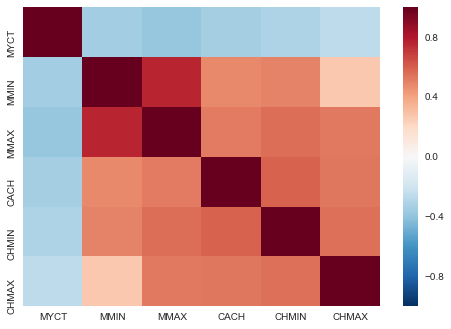

In [3]:
corr = X_traindf.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

count     168.000000
mean      106.904762
std       168.327676
min         6.000000
25%        26.750000
50%        45.500000
75%       113.250000
max      1150.000000
Name: PRP, dtype: float64


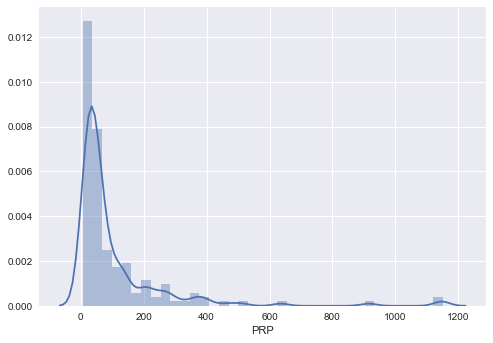

In [4]:
print(y_traindf['PRP'].describe())
# Minimum Performance is larger than zero so we don't have empty values
sns.distplot(y_traindf['PRP']);

Deviate from the normal distribution.
Have appreciable positive skewness.
Show peakedness.

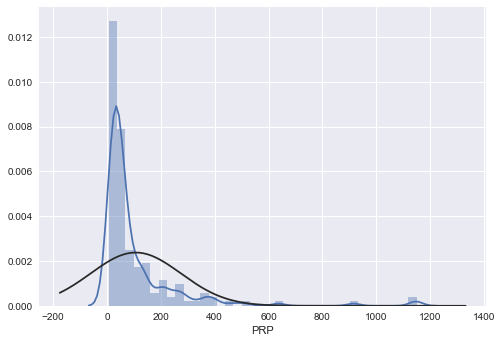

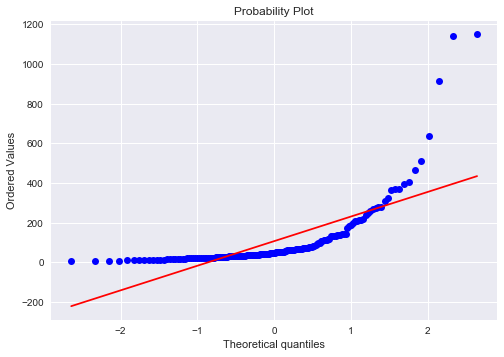

In [5]:
sns.distplot(y_traindf['PRP'], fit=norm);
fig = plt.figure()
res = stats.probplot(y_traindf['PRP'], plot=plt)

In [6]:
y_traindflog = pd.read_csv('y_train.csv')
y_traindflog['PRP'] = np.log(y_traindf['PRP'])

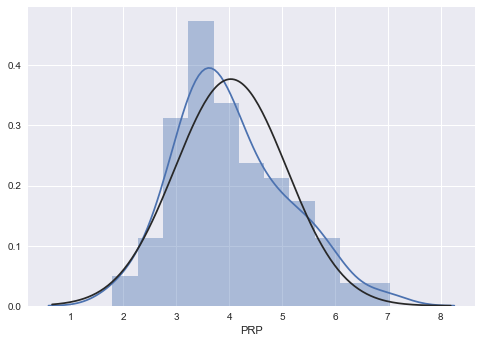

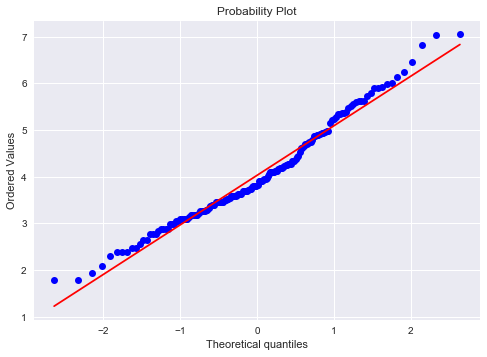

In [7]:
sns.distplot(y_traindflog['PRP'], fit=norm);
fig = plt.figure()
res = stats.probplot(y_traindflog['PRP'], plot=plt)

In [8]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

In [9]:
model_ridge = Ridge()

In [10]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

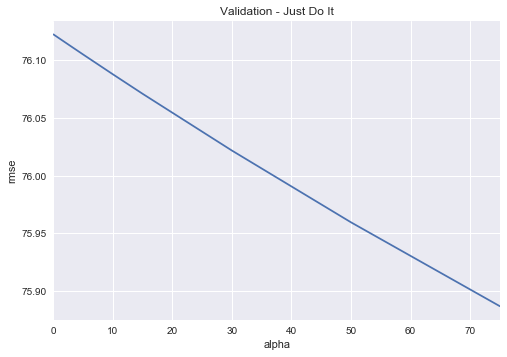

In [11]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [56]:
#Easy Linear regression. Values are negative so is not correct. We need to normalize it first to find the linear relation.
regr = linear_model.LinearRegression(normalize=True)
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [58]:
y_predict = regr.predict(X_test)
print(y_predict)

[  77.64811724   -5.14900668   93.96516664  339.46287713   88.23489811
  -13.59883165   94.48713411   38.70960396  271.53984879  199.11437757
   31.93256642  577.532962     73.15667519  230.82922549  444.87741723
    9.97807406   40.99561298   -6.74167453  -32.87276408   -5.19460371
  -20.72782813   99.44606339  452.23041216   45.9410554    35.21101819
   98.30691306    2.61290018    6.34281005  -21.12898249   42.32172357
   75.85951079   40.63206756   38.29167634  111.01385794  135.49388663
  122.89494729  -12.14308165   53.22506364   -6.09796721  105.20833193
  244.65509804]


#Final export

test_header = "Id,PRP"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = predictions
np.savetxt('my_submission.csv', y_pred_pp, fmt='%d,%f', delimiter=",",
           header=test_header, comments="")

In [71]:
norm_x = X_train/np.linalg.norm(X_train)
normlog_x = np.log(X_train)
print(normlog_x)

[[  4.82831374   5.54517744   8.69951475   5.54517744   2.77258872
    4.85203026]
 [  3.36729583   8.98719682  10.37349118   3.4657359    2.07944154
    3.4657359 ]
 [  3.36729583   8.98719682  10.37349118   3.4657359    2.07944154
    3.4657359 ]
 ..., 
 [  4.82831374   7.60090246   8.98719682         -inf   0.69314718
    2.63905733]
 [  6.1737861    6.23832463   8.98719682   3.4657359          -inf
          -inf]
 [  6.1737861    6.90775528   8.29404964         -inf         -inf
          -inf]]


C:\Users\ignac\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [72]:
from sklearn.tree import DecisionTreeRegressor

# Define model
melbourne_model = DecisionTreeRegressor()

# Fit model
melbourne_model.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [77]:
predictions = (melbourne_model.predict(X_test))

In [78]:
#Final export

test_header = "Id,PRP"
n_points = X_test.shape[0]
y_pred_pp = np.ones((n_points, 2))
y_pred_pp[:, 0] = range(n_points)
y_pred_pp[:, 1] = predictions
np.savetxt('my_submission.csv', y_pred_pp, fmt='%d,%f', delimiter=",",
           header=test_header, comments="")